In [1]:
from __future__ import division
import random

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


%matplotlib inline
#!pip install sklearn
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import pickle

home_dir = '~/Documents/thesis/datasets/'


In [2]:
def balanced_subsample(x, y, subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            this_xs = this_xs.reindex(np.random.permutation(this_xs.index))

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = pd.concat(xs)
    ys = pd.Series(data=np.concatenate(ys),name='target')

    return xs, ys

In [3]:
def normalize_data(x):
    return (x - x.min(0)) / x.ptp(0)

In [4]:
def delete_columns_panda(pandaDataframe, blacklist):
    for element in blacklist:
        del pandaDataframe[element]
    return pandaDataframe

In [5]:
def preprocess_data(data):
    data = data.replace("na", 0)
    data = data.replace("neg", 0)
    data = data.replace("pos", 1)

    return data

In [6]:
def reset_data(with_undersampling=False):
    
    X_train = pd.read_csv(home_dir + 'scania/training_set_new.csv')
    X_test = pd.read_csv(home_dir + 'scania/test_set_new.csv')  
    
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)

    y_train = X_train.iloc[:, 0]  # First column in labels
    y_test = X_test.iloc[:, 0]  # First column in labels

    X_train = X_train.drop(X_train.columns[0], axis=1)  # delete first column of xtrain
    X_test = X_test.drop(X_test.columns[0], axis=1)  # delete first column of xtest

    if with_undersampling:
        X_train, y_train = balanced_subsample(X_train, y_train)
        
    return X_train, X_test, y_train, y_test

In [7]:
def write_predictions_to_file(filename, data):
    f = open(filename, 'w')
    f.write('id,label\n')
    i = 1
    for item in data:
        f.write('%s' % i)
        f.write(',')
        f.write('%s' % int(item))
        f.write('\n')
        i = i+1
    f.close()

In [8]:
def find_cost(predictions, X_train, X_test, y_train, y_test):
    cost_1_instances = 0
    cost_2_instances = 0
    normal_correct = 0
    anomaly_correct = 0
    for i in range(0, len(predictions)):
        if predictions[i] == 0 and y_test[i] == 1:  # He predicted normal but it was anomaly
            cost_2_instances += 1
        elif predictions[i] == 1 and y_test[i] == 0:  # He predicted anomaly but it was normal
            cost_1_instances += 1
        elif predictions[i] == 0 and y_test[i] == 0: # He predicted normal and it was normal
            normal_correct += 1
        elif predictions[i] == 1 and y_test[i] == 1: # He predicted anomaly and it was anomaly
            anomaly_correct += 1

    print (("cost_1_instances are {}".format(cost_1_instances)))
    print (("cost_2_instances are {}".format(cost_2_instances)))
    print (("Correct normal predictions are {}".format(normal_correct)))
    print (("Correct anomaly predictions are {}".format(anomaly_correct)))
    print (("Total Cost is {}".format(10*cost_1_instances + 500*cost_2_instances)))
    

In [9]:
def feature_selection(X_train,y_train):
# Build RF classifier to use in feature selection
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    # Build step forward feature selection
    sfs1 = sfs(clf,
               k_features=5,
               forward=True,
               floating=False,
               verbose=2,
               scoring='accuracy',
               cv=5)

    # Perform SFFS
    sfs1 = sfs1.fit(X_train, y_train)
    
    feat_cols = list(sfs1.k_feature_idx_)
    print(feat_cols)
    
    return feat_cols

In [10]:
def execute_classifier(use_training, clf, X_train, X_test, y_train, y_test, name):

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    # predictions = np.round(predictions)

    if not use_training:
        return predictions
    else:
        prediction_prob = clf.predict_proba(X_test)
        predictions = []
        true_labels = []
        for pr in prediction_prob:
            if pr[0] > 0.95:
                predictions.append(0)  # Neg
            else:
                predictions.append(1)  # Pos

        accuracy = 0
        for i in range(0, len(predictions)):
            if predictions[i] == y_test[i]:
                accuracy +=1
                
        average_precision = average_precision_score(y_test, predictions)
        
        #find average precision recall
        print('Average precision-recall score: {0:0.2f}'.format(average_precision))
        precision, recall, _ = precision_recall_curve(y_test, predictions)

        #plot precision recall

        precision, recall, _ = precision_recall_curve(y_test, predictions)

        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2,
                         color='b')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
                  average_precision))

        write_predictions_to_file(name + '_output.csv.dat', y_test)
        find_cost(predictions, X_train, X_test, y_train, y_test)
        print ("Accuracy of {} is {} %".format(name, round((accuracy)*100, 5)))

        return predictions, accuracy/len(predictions)

In [11]:
# Load data from dat fil
X_train, X_test, y_train, y_test = reset_data(with_undersampling=False) 

Average precision-recall score: 0.33
cost_1_instances are 473
cost_2_instances are 9
Correct normal predictions are 14277
Correct anomaly predictions are 241
Total Cost is 9230
Accuracy of Random Forest is 1451800 %
Accuracy of Random Forest is 96.78667 %


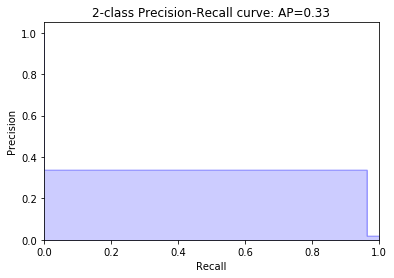

In [12]:
# Define "classifiers" to be used

classifiers = {
    "Random Forest": RandomForestClassifier(criterion="entropy", n_estimators=50),
#     "Extra Trees": ExtraTreesClassifier(n_estimators=250, random_state=0),
#     "Naive Bayes": GaussianNB(),
#     # "SVC": SVC(),
#     #"KNeighborsClassifier": KNeighborsClassifier(3),
#     #"GaussianProcessClassifier": GaussianProcessClassifier(1.0 * RBF(1.0)),
#     'L1 logistic': LogisticRegression(C=C, penalty='l1'),
#     'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2'),
#     'Linear SVC': SVC(kernel='linear', C=C, probability=True,
#                      random_state=0),
#     'L2 logistic (Multinomial)': LogisticRegression(
#     C=C, solver='lbfgs', multi_class='multinomial'),
#     'GPC': GaussianProcessClassifier(kernel)
}

# Pickle trained models
for name, classifier in classifiers.items():
    predictions, accuracy = execute_classifier(True, classifier, X_train, X_test, y_train, y_test, name=name)
    print ("Accuracy of {} is {} %".format(name, round((accuracy)*100, 5)))
    #with open('{}.pickle'.format(name), 'wb') as f:
       # pickle.dump(classifier, f, pickle.HIGHEST_PROTOCOL) '''

In [13]:
X_test.shape

(15000, 170)